This is a sandbox, an almost blank canvas meant to let you fiddle with geodata from any source. The given example should do the following : 
   - We want to find a building, in Geneva, Lausanne or Bern, with less than 48db of noise during night time.
   - The building should be within 200 meters from either a lake or a river
   https://api3.geo.admin.ch/rest/services/api/MapServer/find?layer=ch.bfs.gebaeude_wohnungs_register&searchText=Lausanne&searchField=gdename&returnGeometry=true


In [163]:
import os
import requests
import pandas
import json
import geopandas
import zipfile
import io
import gdal
import fiona
from shapely.geometry import Point

ModuleNotFoundError: No module named 'geoplot'

https://data.geo.admin.ch/ch.bfe.ladestellen-elektromobilitaet/data/ch.bfe.ladestellen-elektromobilitaet_fr.json 200
https://data.geo.admin.ch/ch.bfe.ladestellen-elektromobilitaet/data/oicp/ch.bfe.ladestellen-elektromobilitaet.json 200
https://data.geo.admin.ch/ch.bfe.ladestellen-elektromobilitaet/status/oicp/ch.bfe.ladestellen-elektromobilitaet.json 200
                                              Address  IsOpen24Hours  \
2   {'City': 'Aarau', 'Country': 'CH', 'HouseNum':...           True   
2   {'City': 'Aarau', 'Country': 'CH', 'HouseNum':...           True   
2   {'City': 'Aarau', 'Country': 'CH', 'HouseNum':...           True   
10  {'City': 'Buchs', 'Country': 'CH', 'HouseNum':...           True   
10  {'City': 'Buchs', 'Country': 'CH', 'HouseNum':...           True   

   ChargingStationId                    GeoCoordinates lastUpdate  \
2      CH*IBA*EDC901  {'Google': '8.058373,47.394762'}       None   
2      CH*IBA*EDC901  {'Google': '8.058373,47.394762'}       None   
2  

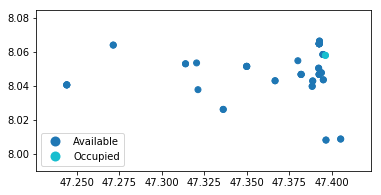

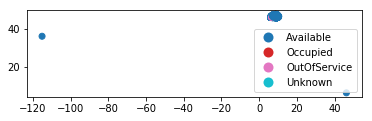

In [162]:
diemo_url = 'https://data.geo.admin.ch/ch.bfe.ladestellen-elektromobilitaet/data/ch.bfe.ladestellen-elektromobilitaet_fr.json'
diemo_full_oicp_data_url = 'https://data.geo.admin.ch/ch.bfe.ladestellen-elektromobilitaet/data/oicp/ch.bfe.ladestellen-elektromobilitaet.json'
diemo_full_oicp_status_url = 'https://data.geo.admin.ch/ch.bfe.ladestellen-elektromobilitaet/status/oicp/ch.bfe.ladestellen-elektromobilitaet.json'
"""layer_id_3 = 'ch.swisstopo.swissboundaries3d-kanton-flaeche.fill' # cantonal boundaries
layer_id_1 = 'ch.bfs.gebaeude_wohnungs_register' # buildings registry
layer_id_2 = 'ch.bafu.laerm-strassenlaerm_nacht' # noise due to road traffic during night time
url_dataset_1 = f'https://data.geo.admin.ch/{layer_id_1}/CSV/CH/CH.zip' # this is a dataset, not an api call. """
r_geojson = requests.get(diemo_url)
r_data = requests.get(diemo_full_oicp_data_url)
r_status = requests.get(diemo_full_oicp_status_url)
print(r_geojson.url, r_geojson.status_code)
print(r_data.url, r_data.status_code)
print(r_status.url, r_status.status_code)
gdf = geopandas.read_file(diemo_url)
dataframe = pandas.DataFrame()
for i in range(len(r_data.json()['EVSEData'])):
    operator_id = r_data.json()['EVSEData'][i]['OperatorID']
    operator_name = r_data.json()['EVSEData'][i]['OperatorName']
    df_1 = pandas.DataFrame(r_data.json()['EVSEData'][i]['EVSEDataRecord'])
    df_2 = pandas.DataFrame(r_status.json()['EVSEStatuses'][i]['EVSEStatusRecord'])
    if df_1.size > 0:
        merged = df_1.merge(df_2, left_on='ChargingStationId', right_on='EvseID', left_index=True, copy=False)
        merged['OperatorID'] = [operator_id for l in range(len(r_data.json()['EVSEData'][i]['EVSEDataRecord']))]
        merged['OperatorName'] = [operator_name for l in range(len(r_data.json()['EVSEData'][i]['EVSEDataRecord']))]
        
        if dataframe.size == 0:
            dataframe = merged
        else:
            dataframe.append(merged)
diemo_data_dataframe = pandas.DataFrame(r_data.json()['EVSEData'])
diemo_status_dataframe = pandas.DataFrame(r_status.json()['EVSEStatuses'])
# data_df = pandas.DataFrame.from_dict((r_data.json()))
# pd = pandas.read_csv(z.read('CH.csv'))
# print(diemo_data_dataframe)
# print(diemo_status_dataframe)
merged['geometry'] = [Point(float(line['Google'].split(',')[1]), float(line['Google'].split(',')[0])) for line in merged['GeoCoordinates']]

gdf_diemo_full = geopandas.GeoDataFrame(merged, geometry="geometry")
gdf_diemo_full.plot(column="EVSEStatus", legend=True)
print(gdf_diemo_full.head())
gdf.plot(column="Availability", legend=True)

{"results":[]}


In [24]:
layer = 'ch.bfs.gebaeude_wohnungs_register'
find_url = f'https://api3.geo.admin.ch/rest/services/api/MapServer/find?layer={layer}&searchText=2740&searchField=plz4&returnGeometry=true'
r_2 = requests.get(find_url)
f_params = {
        'sr': '4326',
        'geometryFormat':'geojson'
    }
preceding_result = ''
for result in r_2.json()['results']:
    feature_url = f'https://api3.geo.admin.ch/rest/services/api/MapServer/{layer}/{result["id"]}{preceding_result}'
    preceding_result = f',{result["id"]}'
    dat_r = requests.get(feature_url, f_params)
    print(dat_r.url, dat_r.status_code)
    print(dat_r.json())

https://api3.geo.admin.ch/rest/services/api/MapServer/ch.bfs.gebaeude_wohnungs_register/1376166_0?sr=4326&geometryFormat=geojson 200
{'feature': {'geometry': {'type': 'Point', 'coordinates': [7.362804, 47.278029]}, 'layerBodId': 'ch.bfs.gebaeude_wohnungs_register', 'bbox': [7.362804, 47.278029, 7.362804, 47.278029], 'featureId': '1376166_0', 'layerName': 'Gebäude- und Wohnungsregister', 'type': 'Feature', 'id': '1376166_0', 'properties': {'gdename': 'Moutier', 'strname1': 'Bel-Air', 'strname_de': None, 'gdekt': 'BE', 'label': 'Bel-Air', 'gstat': 1004, 'egid': 1376166, 'dstrid': 1029269, 'strname_fr': 'Bel-Air', 'strname_rm': None, 'gdenr': 700, 'plz6': 274000, 'bgdi_created': '2020-01-05T04:45:20.452304', 'plz4': 2740, 'plzname': 'Moutier', 'strname_it': None, 'deinr': '7'}}}
https://api3.geo.admin.ch/rest/services/api/MapServer/ch.bfs.gebaeude_wohnungs_register/190358608_0,1376166_0?sr=4326&geometryFormat=geojson 200
{'type': 'FeatureCollection', 'features': [{'geometry': {'type': 'Po